In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

import gc
import time
import pickle
import seaborn as sns
from tqdm import tqdm
from itertools import product
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn import preprocessing 
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

import sys
sys.version_info

sys.version_info(major=3, minor=7, micro=3, releaselevel='final', serial=0)

In [28]:
!pip install xgboost

In [29]:
from xgboost import XGBRegressor
from sklearn import preprocessing 
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [7]:
parser = lambda date: pd.to_datetime(date, format='%d.%m.%Y')

items = pd.read_csv('C:/Users/udbha/Desktop/Python/competitions/competitive-data-science-predict-future-sales/data/items.csv')
shops = pd.read_csv('C:/Users/udbha/Desktop/Python/competitions/competitive-data-science-predict-future-sales/data/shops.csv')
cats = pd.read_csv('C:/Users/udbha/Desktop/Python/competitions/competitive-data-science-predict-future-sales/data/item_categories.csv')
train = pd.read_csv('C:/Users/udbha/Desktop/Python/competitions/competitive-data-science-predict-future-sales/data/sales_train_v2.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('C:/Users/udbha/Desktop/Python/competitions/competitive-data-science-predict-future-sales/data/test.csv')



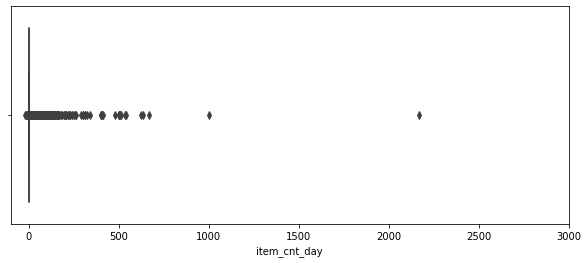

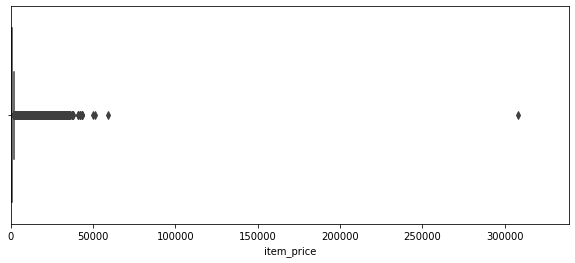

In [9]:


plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)



In [10]:


train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]



In [11]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

In [12]:

train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [13]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

In [14]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [15]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

9.73984956741333

In [16]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']


ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts



5.445004940032959

In [17]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [18]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.16963648796081543

In [19]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

5.174657583236694

In [20]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [21]:


ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts



35.071691274642944

In [22]:


ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts



11.204739809036255

In [23]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

38.73325753211975

In [24]:


ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts



43.59387969970703

In [25]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

16.097057342529297

In [26]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

17.656979084014893

In [27]:


ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts


16.023645162582397

In [28]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

262.7611835002899

In [29]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

16.89619517326355

In [31]:
matrix['month'] = matrix['date_block_num'] % 12

In [32]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [33]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts

961.5347504615784

In [34]:


matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();



In [35]:
data = pd.read_pickle('data.pkl')

In [37]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    #'date_city_avg_item_cnt_lag_1',
    #'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    #'item_last_sale',
    #'item_shop_first_sale',
    #'item_first_sale',
]]

In [38]:


X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)



In [39]:
del data
gc.collect();

In [40]:


ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts



C:\Users\udbha\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\udbha\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:41:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:41:47] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.19201	validation_1-rmse:1.12287
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.15092	validation_1-rmse:1.09122
[2]	validation_0-rmse:1.11614	validation_1-rmse:1.06413
[3]	validation_0-rmse:1.0883	validation_1-rmse:1.04352
[4]	validation_0-rmse:1.06282	validation_1-rmse:1.02518
[5]	validation_0-rmse:1.04208	validation_1-rmse:1.01053
[6]	validation_0-rmse:1.02419	validation_1-rmse:0.998918
[7]	validation_0-rmse:1.00985	vali

4107.988750696182

In [42]:


Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))



In [36]:

train_monthly = pd.DataFrame(train_grp.agg({'item_cnt_day':['sum','count']})).reset_index()
train_monthly.columns = ['date_block_num','shop_id','item_id','item_cnt','item_order']
print(train_monthly[['item_cnt','item_order']].describe())

# trim count
train_monthly['item_cnt'].clip(0, 20, inplace=True)

train_monthly.head()

           item_cnt    item_order
count 7,282,800.000 7,282,800.000
mean          0.222         1.086
std           3.325         0.725
min          -4.000         1.000
25%           0.000         1.000
50%           0.000         1.000
75%           0.000         1.000
max       2,253.000        31.000


,date_block_num,shop_id,item_id,item_cnt,item_order
0,0,2,30,0.000,1
1,0,2,31,0.000,1
2,0,2,32,0.000,1
3,0,2,33,1.000,1
4,0,2,38,0.000,1


create features

In [39]:
# pickup first category name
item_grp = cats['item_category_name'].apply(lambda x: str(x).split(' ')[0])
cats['item_group'] = pd.Categorical(item_grp).codes
#item_cats = item_cats.join(pd.get_dummies(item_grp, prefix='item_group', drop_first=True))
items = pd.merge(items, cats.loc[:,['item_category_id','item_group']], on=['item_category_id'], how='left')

item_grp.unique()

array(['PC', 'Аксессуары', 'Билеты', 'Доставка', 'Игровые', 'Игры',
       'Карты', 'Кино', 'Книги', 'Музыка', 'Подарки', 'Программы',
       'Служебные', 'Чистые', 'Элементы'], dtype=object)

In [40]:
city = shops.shop_name.apply(lambda x: str.replace(x, '!', '')).apply(lambda x: x.split(' ')[0])
shops['city'] = pd.Categorical(city).codes

city.unique()


array(['Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Ярославль'], dtype=object)

In [41]:
# By shop,item
grp = train_monthly.groupby(['shop_id', 'item_id'])
train_shop = grp.agg({'item_cnt':['mean','median','std'],'item_order':'mean'}).reset_index()
train_shop.columns = ['shop_id','item_id','cnt_mean_shop','cnt_med_shop','cnt_std_shop','order_mean_shop']
print(train_shop[['cnt_mean_shop','cnt_med_shop','cnt_std_shop']].describe())

train_shop.head()

       cnt_mean_shop  cnt_med_shop  cnt_std_shop
count    214,200.000   214,200.000   214,200.000
mean           0.188         0.054         0.381
std            0.608         0.509         0.773
min            0.000         0.000         0.000
25%            0.000         0.000         0.000
50%            0.029         0.000         0.171
75%            0.147         0.000         0.431
max           20.000        20.000        10.055


,shop_id,item_id,cnt_mean_shop,cnt_med_shop,cnt_std_shop,order_mean_shop
0,2,30,0.118,0.000,0.327,1.000
1,2,31,0.235,0.000,0.741,1.088
2,2,32,0.324,0.000,0.638,1.088
3,2,33,0.324,0.000,0.535,1.029
4,2,38,0.000,0.000,0.000,1.000


In [42]:


# By shop,item_group
train_cat_monthly = pd.merge(train_monthly, items, on=['item_id'], how='left')
grp = train_cat_monthly.groupby(['shop_id', 'item_group'])
train_shop_cat = grp.agg({'item_cnt':['mean']}).reset_index()
train_shop_cat.columns = ['shop_id','item_group','cnt_mean_shop_cat']
print(train_shop_cat.loc[:,['cnt_mean_shop_cat']].describe())

train_shop_cat.head()



       cnt_mean_shop_cat
count            546.000
mean               0.925
std                2.172
min                0.000
25%                0.029
50%                0.149
75%                0.467
max               13.382


,shop_id,item_group,cnt_mean_shop_cat
0,2,0,0.000
1,2,1,0.352
2,2,3,0.000
3,2,4,0.196
4,2,5,0.292


LAGS


In [43]:
# By month,shop,item At previous
train_prev = train_monthly.copy()
train_prev['date_block_num'] = train_prev['date_block_num'] + 1
train_prev.columns = ['date_block_num','shop_id','item_id','cnt_prev','order_prev']

for i in [2,12]:
    train_prev_n = train_monthly.copy()
    train_prev_n['date_block_num'] = train_prev_n['date_block_num'] + i
    train_prev_n.columns = ['date_block_num','shop_id','item_id','cnt_prev' + str(i),'order_prev' + str(i)]
    train_prev = pd.merge(train_prev, train_prev_n, on=['date_block_num','shop_id','item_id'], how='left')

train_prev.head()

,date_block_num,shop_id,item_id,cnt_prev,order_prev,cnt_prev2,order_prev2,cnt_prev12,order_prev12
0,1,2,30,0.000,1,nan,nan,nan,nan
1,1,2,31,0.000,1,nan,nan,nan,nan
2,1,2,32,0.000,1,nan,nan,nan,nan
3,1,2,33,1.000,1,nan,nan,nan,nan
4,1,2,38,0.000,1,nan,nan,nan,nan


In [44]:


# By month,shop,item_group At previous
grp = pd.merge(train_prev, items, on=['item_id'], how='left').groupby(['date_block_num','shop_id','item_group'])
train_cat_prev = grp['cnt_prev'].mean().reset_index()
train_cat_prev = train_cat_prev.rename(columns={'cnt_prev':'cnt_prev_cat'})
print(train_cat_prev.loc[:,['cnt_prev_cat']].describe())

train_cat_prev.head()



       cnt_prev_cat
count    18,564.000
mean          0.925
std           2.964
min           0.000
25%           0.000
50%           0.096
75%           0.396
max          20.000


,date_block_num,shop_id,item_group,cnt_prev_cat
0,1,2,0,0.000
1,1,2,1,0.280
2,1,2,3,0.000
3,1,2,4,0.000
4,1,2,5,0.100


In [45]:
train_piv = train_monthly.pivot_table(index=['shop_id','item_id'], columns=['date_block_num'], values='item_cnt', aggfunc=np.sum, fill_value=0)
train_piv = train_piv.reset_index()
train_piv.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,30,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,31,0,4,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,32,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,2,33,1,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,1,0
4,2,38,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:


# MACD At previous
col = np.arange(34)
pivT = train_piv[col].T
ema_s = pivT.ewm(span=4).mean().T
ema_m = pivT.ewm(span=12).mean().T
ema_l = pivT.ewm(span=26).mean().T
macd = ema_s - ema_l
sig = macd.ewm(span=9).mean()

ema_list = []
for c in col:
  sub_ema = pd.concat([train_piv.loc[:,['shop_id','item_id']],
      pd.DataFrame(ema_s.loc[:,c]).rename(columns={c:'cnt_ema_s_prev'}),
      pd.DataFrame(ema_m.loc[:,c]).rename(columns={c:'cnt_ema_m_prev'}),
      pd.DataFrame(ema_l.loc[:,c]).rename(columns={c:'cnt_ema_l_prev'}),
      pd.DataFrame(macd.loc[:,c]).rename(columns={c:'cnt_macd_prev'}),
      pd.DataFrame(sig.loc[:,c]).rename(columns={c:'cnt_sig_prev'})], axis=1)
  sub_ema['date_block_num'] = c + 1
  ema_list.append(sub_ema)
    
train_ema_prev = pd.concat(ema_list)
train_ema_prev.head()



,shop_id,item_id,cnt_ema_s_prev,cnt_ema_m_prev,cnt_ema_l_prev,cnt_macd_prev,cnt_sig_prev,date_block_num
0,2,30,0.000,0.000,0.000,0.000,0.000,1
1,2,31,0.000,0.000,0.000,0.000,0.000,1
2,2,32,0.000,0.000,0.000,0.000,0.000,1
3,2,33,1.000,1.000,1.000,0.000,0.000,1
4,2,38,0.000,0.000,0.000,0.000,0.000,1


In [64]:


# Price mean by month,shop,item
train_price = train_grp['item_price'].mean().reset_index()
price = train_price[~train_price['item_price'].isnull()]

# last price by shop,item
last_price = price.drop_duplicates(subset=['shop_id', 'item_id'], keep='last').drop(['date_block_num'], axis=1)

# null price by shop,item
'''
mean_price = price.groupby(['item_id'])['item_price'].mean().reset_index()
result_price = pd.merge(test, mean_price, on=['item_id'], how='left').drop('ID', axis=1)
pred_price_set = result_price[result_price['item_price'].isnull()]
'''
uitem = price['item_id'].unique()
pred_price_set = test[~test['item_id'].isin(uitem)].drop('ID', axis=1)



In [65]:
_ = '''
'''
if len(pred_price_set) > 0:
    train_price_set = pd.merge(price, items, on=['item_id'], how='inner')
    pred_price_set = pd.merge(pred_price_set, items, on=['item_id'], how='inner').drop(['item_name'], axis=1)
    reg = ensemble.ExtraTreesRegressor(n_estimators=25, n_jobs=-1, max_depth=15, random_state=42)
    reg.fit(train_price_set[pred_price_set.columns], train_price_set['item_price'])
    pred_price_set['item_price'] = reg.predict(pred_price_set)

test_price = pd.concat([last_price, pred_price_set], join='inner')
test_price.head()

,shop_id,item_id,item_price
209,2,1204,299.000
211,2,1224,399.000
219,2,1247,299.000
826,2,3656,299.000
1064,2,4531,279.000


In [66]:


price_max = price.groupby(['item_id']).max()['item_price'].reset_index()
price_max.rename(columns={'item_price':'item_max_price'}, inplace=True)
price_max.head()



,item_id,item_max_price
0,30,399.000
1,31,699.000
2,32,349.000
3,33,499.000
4,38,"2,399.000"


In [67]:
train_price_a = pd.merge(price, price_max, on=['item_id'], how='left')
train_price_a['discount_rate'] = 1 - (train_price_a['item_price'] / train_price_a['item_max_price'])
train_price_a.drop('item_max_price', axis=1, inplace=True)
train_price_a.head()

,date_block_num,shop_id,item_id,item_price,discount_rate
0,0,2,33,499.000,0.000
1,0,2,482,"3,300.000",0.000
2,0,2,491,600.000,0.000
3,0,2,839,"3,300.000",0.000
4,0,2,1007,449.000,0.626


In [68]:
test_price_a = pd.merge(test_price, price_max, on=['item_id'], how='left')
test_price_a.loc[test_price_a['item_max_price'].isnull(), 'item_max_price'] = test_price_a['item_price']
test_price_a['discount_rate'] = 1 - (test_price_a['item_price'] / test_price_a['item_max_price'])
test_price_a.drop('item_max_price', axis=1, inplace=True)
test_price_a.head()

,shop_id,item_id,item_price,discount_rate
0,2,1204,299.000,0.000
1,2,1224,399.000,0.111
2,2,1247,299.000,0.000
3,2,3656,299.000,0.143
4,2,4531,279.000,0.067


In [75]:


def mergeFeature(df): 
  df = pd.merge(df, items, on=['item_id'], how='left').drop('item_group', axis=1)
  df = pd.merge(df, cats, on=['item_category_id'], how='left')
  df = pd.merge(df, shops, on=['shop_id'], how='left')

  df = pd.merge(df, train_shop, on=['shop_id','item_id'], how='left')
  df = pd.merge(df, train_shop_cat, on=['shop_id','item_group'], how='left')
  df = pd.merge(df, train_prev, on=['date_block_num','shop_id','item_id'], how='left')
  df = pd.merge(df, train_cat_prev, on=['date_block_num','shop_id','item_group'], how='left')
  df = pd.merge(df, train_ema_prev, on=['date_block_num','shop_id','item_id'], how='left')
  
  df['month'] = df['date_block_num'] % 12
  days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
  df['days'] = df['month'].map(days).astype(np.int8)
  
  df.drop(['shop_id','shop_name','item_id','item_name','item_category_id','item_category_name','item_group'], axis=1, inplace=True)
  df.fillna(0.0, inplace=True)
  return df



In [76]:
train_set = train_monthly[train_monthly['date_block_num'] >= 12]

train_set = pd.merge(train_set, train_price_a, on=['date_block_num','shop_id','item_id'], how='left')
train_set = mergeFeature(train_set)

train_set = train_set.join(pd.DataFrame(train_set.pop('item_order'))) # move to last column
X_train = train_set.drop(['item_cnt'], axis=1)
#Y_train = train_set['item_cnt']
Y_train = train_set['item_cnt'].clip(0.,20.)
X_train.head()

,date_block_num,item_price,discount_rate,city,cnt_mean_shop,cnt_med_shop,cnt_std_shop,order_mean_shop,cnt_mean_shop_cat,cnt_prev,...,order_prev12,cnt_prev_cat,cnt_ema_s_prev,cnt_ema_m_prev,cnt_ema_l_prev,cnt_macd_prev,cnt_sig_prev,month,days,item_order
0,12,0.000,0.000,0,0.118,0.000,0.327,1.000,0.039,0.000,...,1.000,0.040,0.023,0.105,0.139,-0.116,-0.116,0,31,1
1,12,0.000,0.000,0,0.235,0.000,0.741,1.088,0.039,0.000,...,1.000,0.040,0.020,0.220,0.355,-0.335,-0.238,0,31,1
2,12,119.000,0.659,0,0.324,0.000,0.638,1.088,0.039,0.000,...,1.000,0.040,0.000,0.000,0.000,0.000,-0.140,0,31,1
3,12,199.000,0.601,0,0.324,0.000,0.535,1.029,0.039,1.000,...,1.000,0.040,0.883,0.507,0.403,0.480,0.070,0,31,1
4,12,0.000,0.000,0,0.000,0.000,0.000,1.000,0.039,0.000,...,1.000,0.040,0.000,0.000,0.000,0.000,0.049,0,31,1


In [79]:
test_set = test.copy()
test_set['date_block_num'] = 34

test_set = pd.merge(test_set, test_price_a, on=['shop_id','item_id'], how='left')
test_set = mergeFeature(test_set)

test_set['item_order'] = test_set['cnt_ema_s_prev'] #order_prev
test_set.loc[test_set['item_order'] == 0, 'item_order'] = 1

X_test = test_set.drop(['ID'], axis=1)
X_test.head()

assert(X_train.columns.isin(X_test.columns).all())

In [80]:
!pip install lightgbm

In [81]:
from sklearn import linear_model, preprocessing
from sklearn.model_selection import GroupKFold
import lightgbm as lgb

params={'learning_rate': 0.05,
        'objective':'regression',
        'metric':'rmse',
        'num_leaves': 64,
        'verbose': 1,
        'random_state':42,
        'bagging_fraction': 1,
        'feature_fraction': 1
       }

folds = GroupKFold(n_splits=6)
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])

for fold_, (trn_, val_) in enumerate(folds.split(X_train, Y_train, X_train['date_block_num'])):
    trn_x, trn_y = X_train.iloc[trn_], Y_train[trn_]
    val_x, val_y = X_train.iloc[val_], Y_train[val_]

    reg = lgb.LGBMRegressor(**params, n_estimators=3000)
    reg.fit(trn_x, trn_y, eval_set=[(val_x, val_y)], early_stopping_rounds=50, verbose=500)
    
    oof_preds[val_] = reg.predict(val_x.values, num_iteration=reg.best_iteration_)
    sub_preds += reg.predict(X_test.values, num_iteration=reg.best_iteration_) / folds.n_splits

Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 0.209551
[1000]	valid_0's rmse: 0.207529
Early stopping, best iteration is:
[1436]	valid_0's rmse: 0.206936
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 0.207299
[1000]	valid_0's rmse: 0.205467
Early stopping, best iteration is:
[1140]	valid_0's rmse: 0.205181
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 0.209021
[1000]	valid_0's rmse: 0.207211
Early stopping, best iteration is:
[1235]	valid_0's rmse: 0.206766
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 0.185137
Early stopping, best iteration is:
[507]	valid_0's rmse: 0.185126
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 0.157943
Early stopping, best iteration is:
[532]	valid_0's rmse: 0.157825
Training until validation scores don't improve for 50 rounds.
[500]	valid_0's rmse: 0.187707
Early stoppin

In [82]:
pred_cnt = sub_preds

In [83]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_train, oof_preds.clip(0.,20.))))

RMSE: 0.1936225863474259


In [84]:
result = pd.DataFrame({
    "ID": test["ID"],
    "item_cnt_month": pred_cnt.clip(0. ,20.)
})
result.to_csv("submission.csv", index=False)